In this notebook i attemped to predict next month's order demand using time series analysis and time series forecasting methods

### Importing Libraries.

In [1]:
# Just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
sns.set()
import plotly as py
# Import dependencies
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
# Configure Plotly to be rendered inline in the notebook.
py.offline.init_notebook_mode(connected=True)
import itertools
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Read data set from manufacturer and explore the features

In [ ]:
df = pd.read_csv('HPD2.csv', parse_dates=['Date'])
df.head()

In [3]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [4]:
df.nunique()

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1712
Order_Demand        3282
dtype: int64

 1. Product Code (categorical): 2160 products
 2. Warehouse (categorical): 4 warehouses
 3. Product category (categorical): 33 categories
 4. Date (date): demand fulfillment date
 5. Order demanded (integer): target demand value

In [5]:
df.Product_Code.unique()

array(['Product_1507', 'Product_0608', 'Product_1933', ...,
       'Product_0465', 'Product_1013', 'Product_0853'], dtype=object)

In [6]:
df.Product_Category.unique()

array(['Category_019', 'Category_001', 'Category_023', 'Category_028',
       'Category_006', 'Category_007', 'Category_021', 'Category_004',
       'Category_015', 'Category_024', 'Category_030', 'Category_026',
       'Category_003', 'Category_018', 'Category_009', 'Category_032',
       'Category_011', 'Category_020', 'Category_013', 'Category_005',
       'Category_022', 'Category_031', 'Category_010', 'Category_033',
       'Category_017', 'Category_008', 'Category_029', 'Category_025',
       'Category_012', 'Category_014', 'Category_002', 'Category_027',
       'Category_016'], dtype=object)

In [7]:
df['Product_Category'].value_counts()

Category_019    445251
Category_005    100711
Category_001     96841
Category_007     81159
Category_021     50938
Category_006     35098
Category_028     28923
Category_011     22973
Category_015     22437
Category_024     20371
Category_009     19253
Category_026     14508
Category_030     12958
Category_032      9240
Category_022      8516
Category_023      7826
Category_018      5150
Category_003      4111
Category_013      3658
Category_020      3432
Category_031      2209
Category_033      1833
Category_008      1540
Category_012      1113
Category_010       945
Category_029       645
Category_017       602
Category_004       325
Category_002        76
Category_016        37
Category_025        35
Category_014        26
Category_027        21
Name: Product_Category, dtype: int64

### Group by product category and make it in order by count. We want to get the order demand for top three categories.


In [8]:
Cat_fltr = df.groupby(['Product_Category']).size().reset_index(name='Cat_count').sort_values(['Cat_count'],ascending=False)
Cat_fltr.head(10)

,Product_Category,Cat_count
18,Category_019,445251
4,Category_005,100711
0,Category_001,96841
6,Category_007,81159
20,Category_021,50938
5,Category_006,35098
27,Category_028,28923
10,Category_011,22973
14,Category_015,22437
23,Category_024,20371


In [9]:
#df.groupby('Product_Category')['Order_Demand'].sum()

### Let's look at the highest product code in demand as well.

In [10]:
Code_fltr = df.groupby(['Product_Code']).size().reset_index(name='Code_count').sort_values(['Code_count'],ascending=False)
Code_fltr.head(10)

,Product_Code,Code_count
1348,Product_1359,16861
1284,Product_1295,10443
1367,Product_1378,9652
619,Product_0620,9367
1275,Product_1286,8790
1371,Product_1382,8520
1442,Product_1453,8385
1283,Product_1294,8313
1366,Product_1377,7761
1276,Product_1287,7727


### Categories  1, 5 and 19 are with top three counts. We are using Category_001 as an example to predict next month product category demand

### Let's make our Category_001 as a separate data frame and start preparing it for our forecast

In [11]:
Category_001 = df.loc[df['Product_Category'] == 'Category_001'] #.sort_values(['Date'],ascending=False)
Category_001.describe()

,Order_Demand
count,96841.000000
mean,17.997914
std,53.364740
min,1.000000
25%,1.000000
50%,5.000000
75%,15.000000
max,2075.000000


In [12]:
# Look at the available start and end date stamps
Category_001['Date'].min(), Category_001['Date'].max()

(Timestamp('2011-09-27 00:00:00'), Timestamp('2017-01-06 00:00:00'))

### Data Preprocessing

In [13]:
cols = [ 'Product_Code', 'Warehouse', 'Product_Category']
Category_001.drop(cols, axis=1, inplace=True)
Category_001 = Category_001.sort_values('Date')
Category_001.isnull().sum()

Date            0
Order_Demand    0
dtype: int64

<strong>We have daily data. We want to aggregate demand for Category 001 by year and month - grouping by month<strong>. 

In [14]:
Category_001[['year','month']] = Category_001.Date.apply(lambda x: pd.Series(x.strftime("%Y,%m").split(",")))
Category_001 = Category_001.groupby(['year', 'month', ])[['Order_Demand']].sum().reset_index()
Category_001=Category_001[['year', 'month', 'Order_Demand']]
Category_001

,year,month,Order_Demand
0,2011,09,28
1,2011,12,957
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159


### Create pivot table to look at monthly product demand

In [15]:
Category_001_pivot = Category_001.pivot('month', 'year', 'Order_Demand')
Category_001_pivot

year,2011,2012,2013,2014,2015,2016,2017
month,,,,,,,
01,NaN,22172.0,22281.0,26276.0,35569.0,31214.0,29.0
02,NaN,25866.0,29030.0,26665.0,37465.0,33834.0,NaN
03,NaN,30002.0,26776.0,36264.0,34587.0,39711.0,NaN
04,NaN,20960.0,24464.0,25970.0,30803.0,32248.0,NaN
05,NaN,20391.0,21452.0,28438.0,25452.0,26485.0,NaN
06,NaN,21214.0,22989.0,29207.0,36159.0,35364.0,NaN
07,NaN,20313.0,30267.0,32801.0,34183.0,31433.0,NaN
08,NaN,18159.0,24993.0,28950.0,29797.0,26377.0,NaN
09,28.0,19864.0,27373.0,30246.0,27524.0,33249.0,NaN


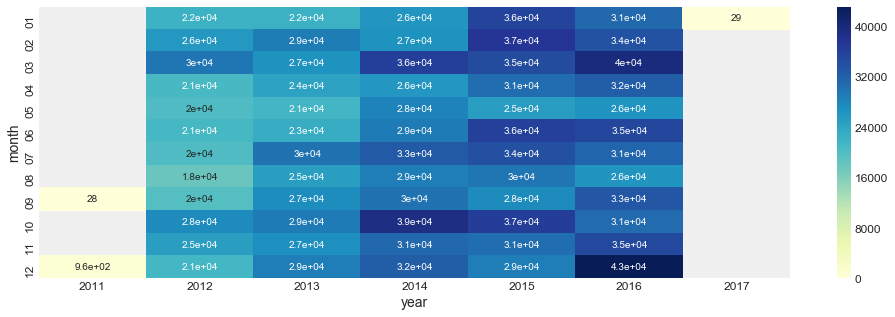

In [16]:
plt.figure(figsize=(15, 5))
sns.heatmap(Category_001_pivot, annot = True, cmap = "YlGnBu")

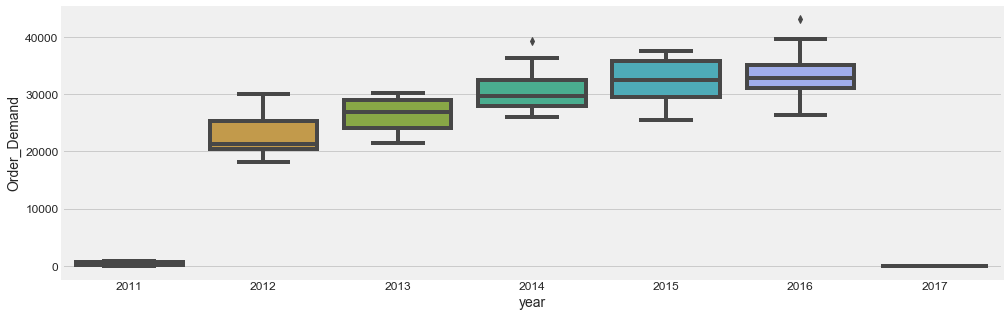

In [17]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="year", y="Order_Demand", data=Category_001)

## Indexing with Time Series Data

In [18]:
#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#Category_001 = Category_001.set_index('Date')
#Category_001.index
Category_001 = Category_001.drop(Category_001.index[[0,1]])
Category_001 = Category_001.drop(Category_001.index[[-1]])
Category_001

,year,month,Order_Demand
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159
10,2012,09,19864
11,2012,10,27648


### Combine dates and create datetime index to prepare Category_001 dataset for time series forecast

In [26]:
Category_001['Timestamp'] = pd.date_range('20120131', periods = 60, freq = 'M')


In [27]:
y = Category_001.loc[:, ('Order_Demand')]
y.head(10), 


(Timestamp
 2012-01-31    22172
 2012-02-29    25866
 2012-03-31    30002
 2012-04-30    20960
 2012-05-31    20391
 2012-06-30    21214
 2012-07-31    20313
 2012-08-31    18159
 2012-09-30    19864
 2012-10-31    27648
 Name: Order_Demand, dtype: int64,)

In [28]:
Category_001 = Category_001.set_index('Timestamp')
Category_001.index

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
      

In [29]:
#y = Category_001['Order_Demand'].resample('MS').mean()

In [30]:
#df.index = pd.to_datetime(df.index, unit='s')

### Visualizing Order Demand for Category_001

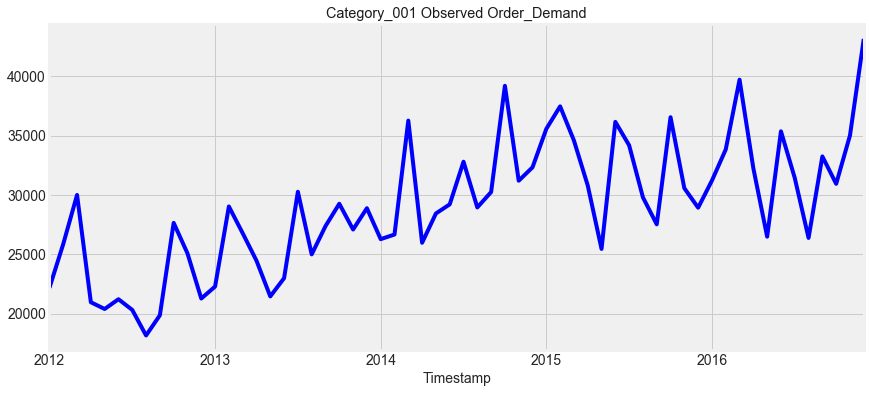

In [31]:
y.plot(figsize=(13,6), title= 'Category_001 Observed Order_Demand', fontsize=14, color="Blue")
plt.show()

In [46]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

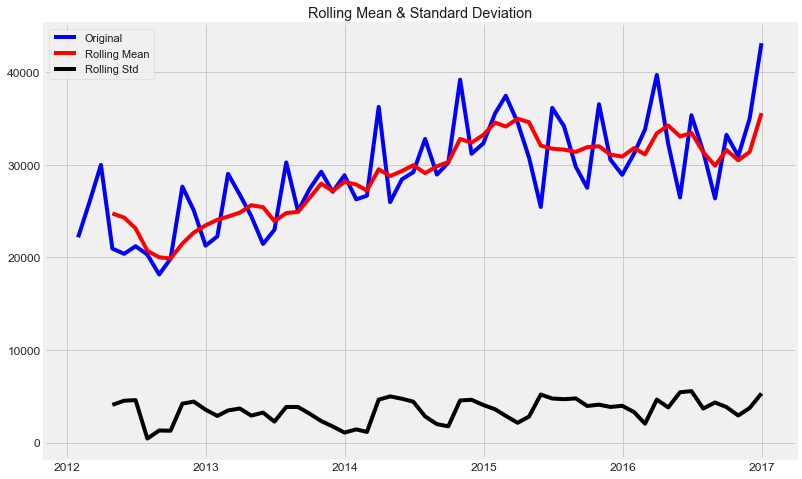

Results of Dickey-Fuller Test:
Test Statistic                 -1.598773
p-value                         0.484210
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [54]:
test_stationarity(y)

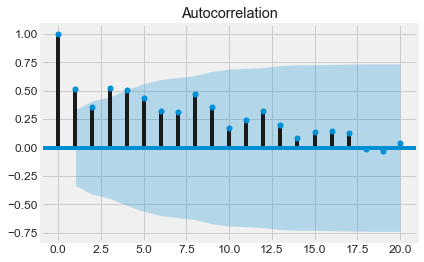

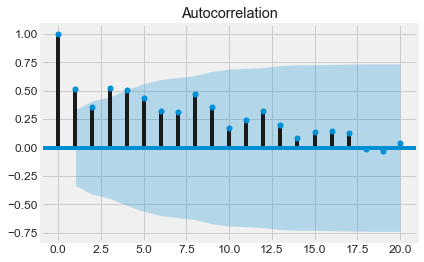

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=20, alpha=0.01) 
#plot_acf(y, lags=20, alpha=0.05)


### Split data for each category into train and test sets - 80/20%

In [67]:
#train, test = y[:48], y[:12]
train = y.loc['2012-01-31':'2015-12-31']
test = y.loc['2015-12-31':]
train.shape, test.shape


((48,), (13,))

In [68]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)

### Visualize train and test sets

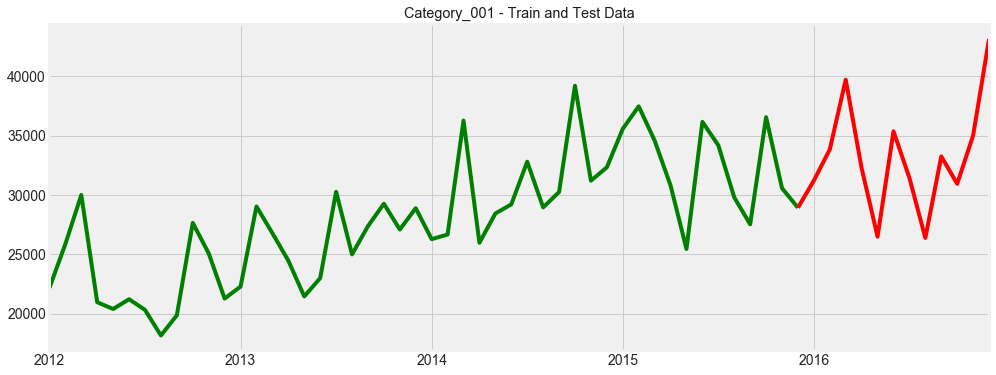

In [69]:
train.plot(figsize=(15,6), title= 'Category_001 - Train and Test Data', fontsize=12,color="Green")
test.plot(figsize=(15,6), fontsize=14, color="Red")
plt.show();

### Simple smoothing

In [70]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

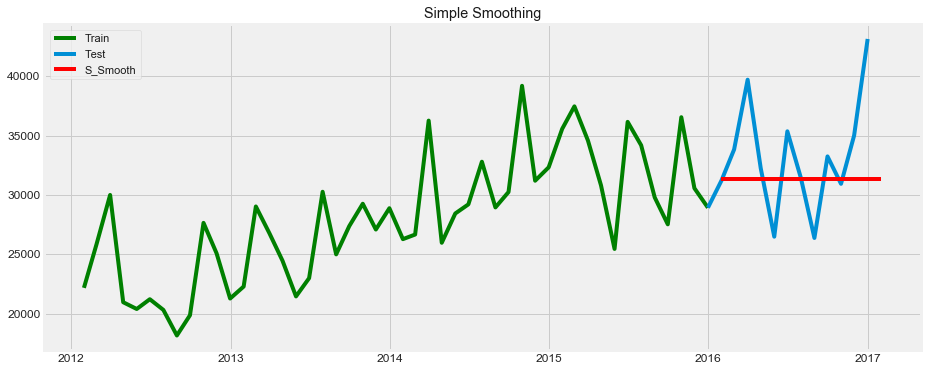

In [71]:
#simple smoothing
s_avg = test.copy()
fit_s = SimpleExpSmoothing(train).fit(smoothing_level=0.2,optimized=False)
s_avg['S_Smooth'] = fit_s.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot(train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(s_avg['S_Smooth'], label='S_Smooth',color="Red")
plt.title("Simple Smoothing")
plt.legend(loc='best')
plt.show()




In [72]:
import math
from sklearn.metrics import mean_squared_error
SS_RMSE = math.sqrt(mean_squared_error(test, s_avg.S_Smooth))
print('SS_RMSE: %f' % SS_RMSE)

SS_RMSE: 4828.459132


In [73]:
from sklearn.metrics import mean_absolute_error
SS_MAE = mean_absolute_error(test, s_avg.S_Smooth) 
print('SS_MAE: %f' % SS_MAE)

SS_MAE: 3535.982765


### Exponential smoothing

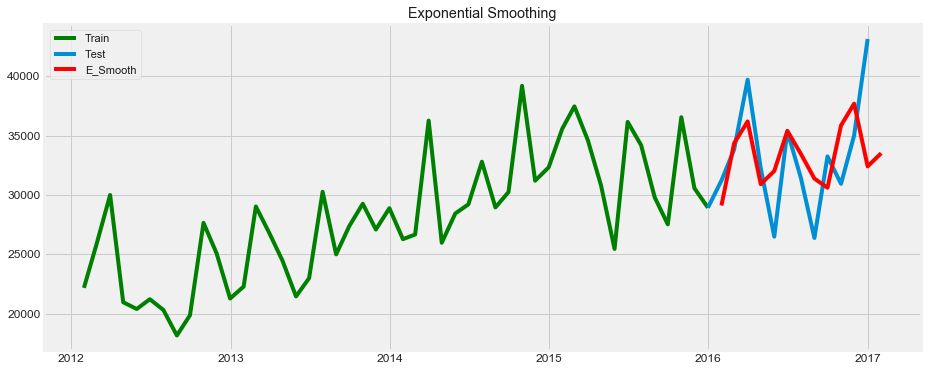

In [74]:
# Exponential Smoothing

exp_avg = test.copy()
fit_e = ExponentialSmoothing(train, seasonal_periods=8 ,trend='additive', seasonal='additive',).fit()
exp_avg['E_Smooth'] = fit_e.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot( train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(exp_avg['E_Smooth'], label='E_Smooth',color="Red")
plt.legend(loc='best')
plt.title("Exponential Smoothing");
plt.show()

In [75]:
ES_RMSE = math.sqrt(mean_squared_error(test, exp_avg.E_Smooth))
print('ES_RMSE: %f' % ES_RMSE)

ES_RMSE: 5157.288640


In [76]:
ES_MAE = mean_absolute_error(test, exp_avg.E_Smooth) 
print('ES_MAE: %f' % ES_MAE)

ES_MAE: 3954.121580


## Holt's Linear Trend

### Let's create time-series decomposition plot

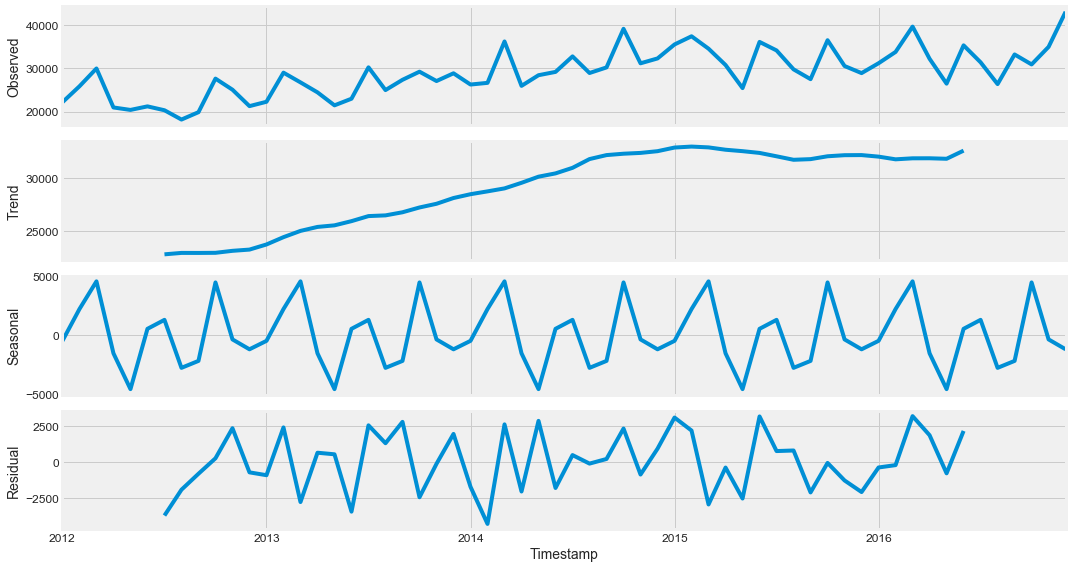

In [77]:
#Time-series decomposition plot
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
res = sm.tsa.seasonal_decompose(y.interpolate(), model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

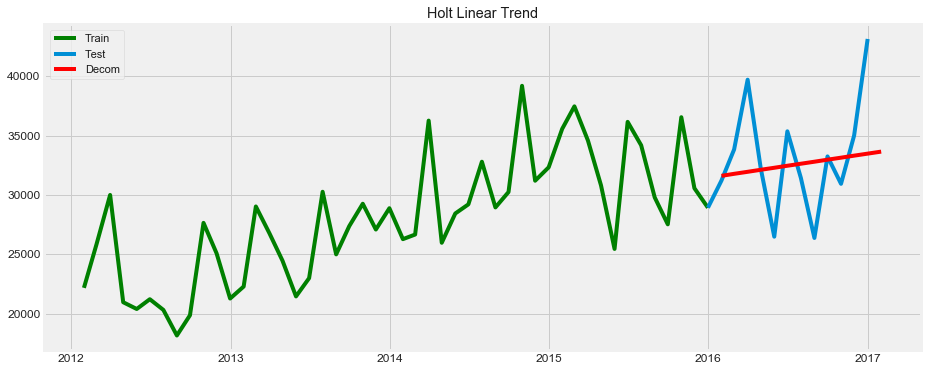

In [78]:
decom_avg = test.copy()

fit_d = Holt(train).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
decom_avg['Decomp'] = fit_d.forecast(len(test))

plt.figure(figsize=(14,6))
plt.plot(train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(decom_avg['Decomp'], label='Decom',color="Red")
plt.legend(loc='best')
plt.title("Holt Linear Trend");
plt.show()

In [79]:
HL_RMSE = math.sqrt(mean_squared_error(test, decom_avg.Decomp))
print('HL_RMSE: %f' % HL_RMSE)

HL_RMSE: 4431.645674


In [80]:
HL_MAE = mean_absolute_error(test, decom_avg.Decomp) 
print('HL_MAE: %f' % HL_MAE)

HL_MAE: 3303.156113


## Holt-Winters Method

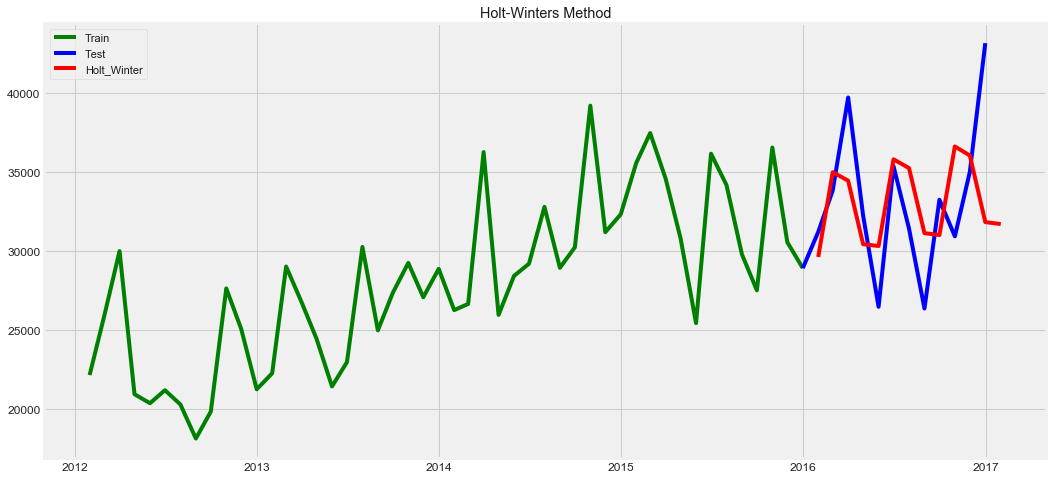

In [81]:
hw_avg = test.copy()
fit_hw = ExponentialSmoothing(train , seasonal_periods=4 ,trend='add', seasonal='mul',).fit()
hw_avg['Holt_Winter'] = fit_hw.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train, label='Train', color="Green")
plt.plot(test, label='Test', color="Blue")
plt.plot(hw_avg['Holt_Winter'], label='Holt_Winter', color="Red")
plt.legend(loc='best')
plt.title("Holt-Winters Method");
plt.show()

In [82]:
HW_RMSE = math.sqrt(mean_squared_error(test, hw_avg.Holt_Winter))
print('HW_RMSE: %f' % HW_RMSE)

HW_RMSE: 5488.049450


In [83]:
HW_MAE = mean_absolute_error(test, hw_avg.Holt_Winter) 
print('HW_MAE: %f' % HW_MAE)

HW_MAE: 4134.765021


## ARIMA model

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



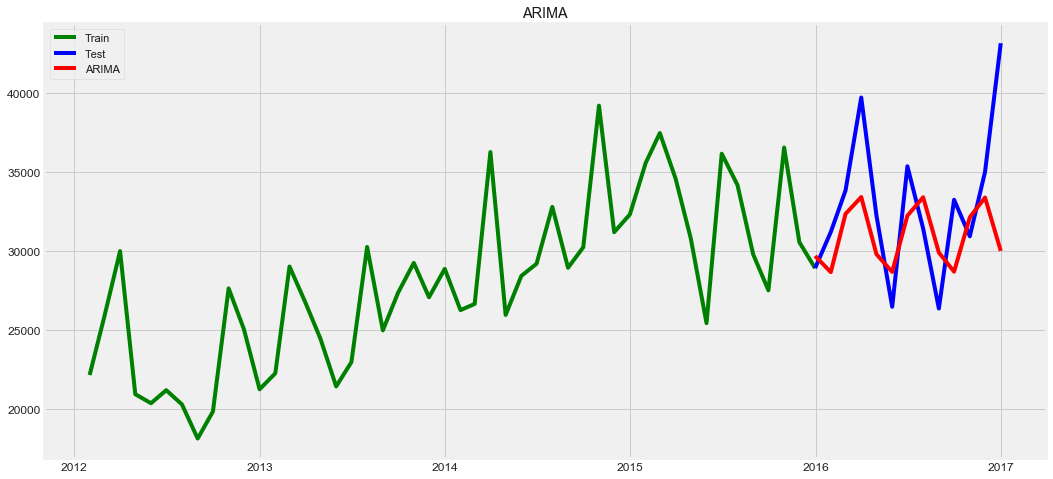

In [215]:
arima_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 3)).fit()
arima_avg['ARIMA'] = fit_arima.predict(start="2015-12-31", end="2016-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train', color="Green")
plt.plot(test, label='Test', color="Blue")
plt.plot(arima_avg['ARIMA'], label='ARIMA', color="Red")
plt.legend(loc='best')
plt.title("ARIMA");
plt.show()

In [218]:
A_RMSE = math.sqrt(mean_squared_error(test, arima_avg.ARIMA))
print('A_RMSE: %f' % A_RMSE)

A_RMSE: 4663.627622


In [220]:
from sklearn.metrics import mean_absolute_error
A_MAE = mean_absolute_error(test, arima_avg.ARIMA) 
print('A_MAE: %f' % A_MAE)

A_MAE: 3449.579716


## SARIMA model

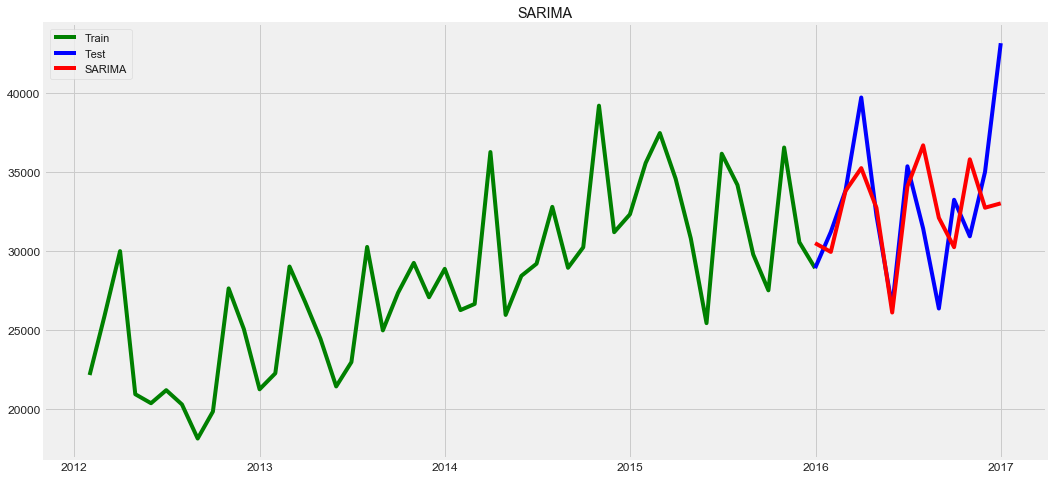

In [241]:
sarima_avg = test.copy()
fit_sarima = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 4),seasonal_order=(0,1,1,6)).fit()
sarima_avg['SARIMA'] = fit_sarima.predict(start="2015-12-31", end="2016-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train, label='Train', color="Green")
plt.plot(test, label='Test', color="Blue")
plt.plot(sarima_avg['SARIMA'], label='SARIMA', color="Red")
plt.legend(loc='best')
plt.title("SARIMA");
plt.show()

In [242]:
SA_RMSE = math.sqrt(mean_squared_error(test, sarima_avg.SARIMA))
print('SA_RMSE: %f' % SA_RMSE)

SA_RMSE: 4176.116086


## Seasonal ARIMA models are denoted with the notation parameters (p, d, q) and accountable for data seasonality, trend, and noise :

In [109]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Optimal set of parameters that yields the best performance for the SARIMA

In [131]:
from pmdarima.arima import auto_arima
mod = auto_arima(y, start_p=1, start_q=1,max_p=3, max_q=3, m=25,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,)
print(mod.bic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 25); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 25); AIC=712.679, BIC=715.731, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 25); AIC=702.119, BIC=708.224, Fit time=0.318 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 25); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 25); AIC=709.355, BIC=713.934, Fit time=0.054 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 25); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 25); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 25); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 25); AIC=700.888, BIC=705.467, Fit time=0.764 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 25); AIC=696.004, BIC=702.109, Fit time=0.36

## Fit seasonal ARIMA model

In [205]:
mod = sm.tsa.statespace.SARIMAX(y, trend='n', order=(1, 1, 1),seasonal_order=(0, 1, 0, 14),enforce_invertibility=False)
results = mod.fit()
print (results.summary())

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



                                 Statespace Model Results                                 
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 14)   Log Likelihood                -463.722
Date:                            Tue, 16 Jul 2019   AIC                            933.444
Time:                                    22:25:44   BIC                            938.864
Sample:                                01-31-2012   HQIC                           935.464
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3468      0.139      2.491      0.013       0.074       0.620
ma.L1         -1.1818      0.110   

## Plot diagnostics to investigate unusual model behavior 

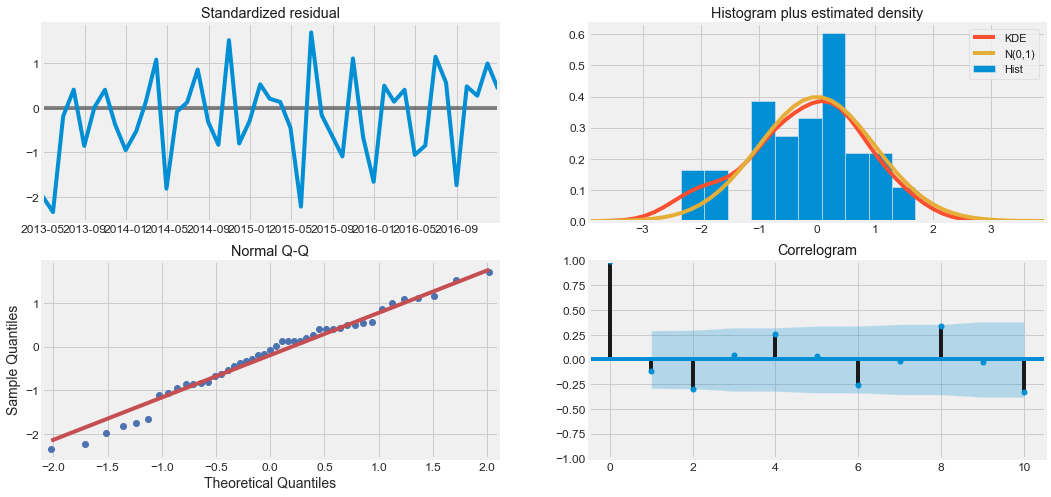

In [206]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validate the accuracy of product demand forecast looking at predicted mean for test set of data 

            lower Order_Demand  upper Order_Demand
2016-01-31        13214.487381        41913.424107
2016-02-29        18469.934138        47168.869924
2016-03-31        22384.409622        51083.344734
2016-04-30        25652.501089        54351.435719
2016-05-31        18336.169003        47035.103288
2016-06-30        12597.851836        41296.785873
2016-07-31        12932.896057        41631.829918
2016-08-31        24770.824126        53469.757860
2016-09-30        15368.189129        44067.122773
2016-10-31        14593.743499        43292.677078
2016-11-30        13347.176400        42046.109932
2016-12-31        25699.029426        54397.962925


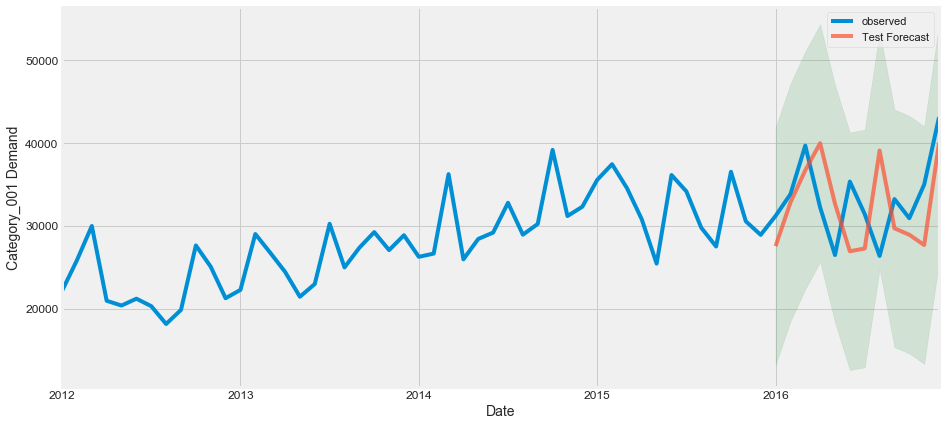

In [207]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Test Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()

In [208]:
y_forecasted = pred.predicted_mean
print(y_forecasted)

2016-01-31    27563.955744
2016-02-29    32819.402031
2016-03-31    36733.877178
2016-04-30    40001.968404
2016-05-31    32685.636146
2016-06-30    26947.318854
2016-07-31    27282.362987
2016-08-31    39120.290993
2016-09-30    29717.655951
2016-10-31    28943.210288
2016-11-30    27696.643166
2016-12-31    40048.496175
Freq: M, dtype: float64


## Visualizing future product demand forecast 

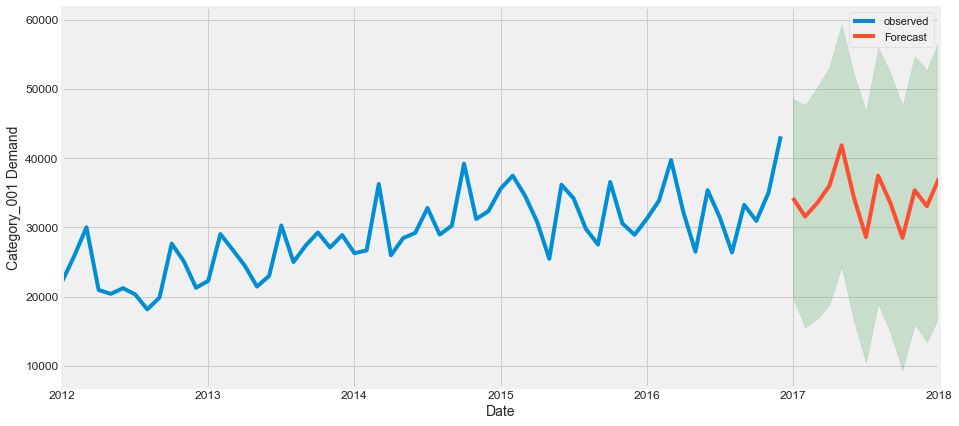

            lower Order_Demand  upper Order_Demand
2017-01-31        19883.539135        48582.472610
2017-02-28        15528.158393        47622.411326
2017-03-31        16790.217602        50231.885579
2017-04-30        18853.525994        53164.281216
2017-05-31        24327.157889        59359.931994
2017-06-30        16515.978926        52215.732555
2017-07-31        10427.268160        46768.255434
2017-08-31        18991.731892        55958.258731
2017-09-30        14753.333054        52333.432400
2017-10-31         9395.528850        47578.811738
2017-11-30        15970.644749        54747.548504
2017-12-31        13367.315474        52728.826685
2018-01-31        17152.291758        57089.832682


In [247]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()
print(pred_ci)
print(pred_uc)

## Our Category_001 predicted demand in January 2017 

In [213]:
pred_uc.predicted_mean[0:3]

2017-01-31    34233.005873
2017-02-28    31575.284860
2017-03-31    33511.051591
Freq: M, dtype: float64

## Root Mean Square Error Comparison Plot

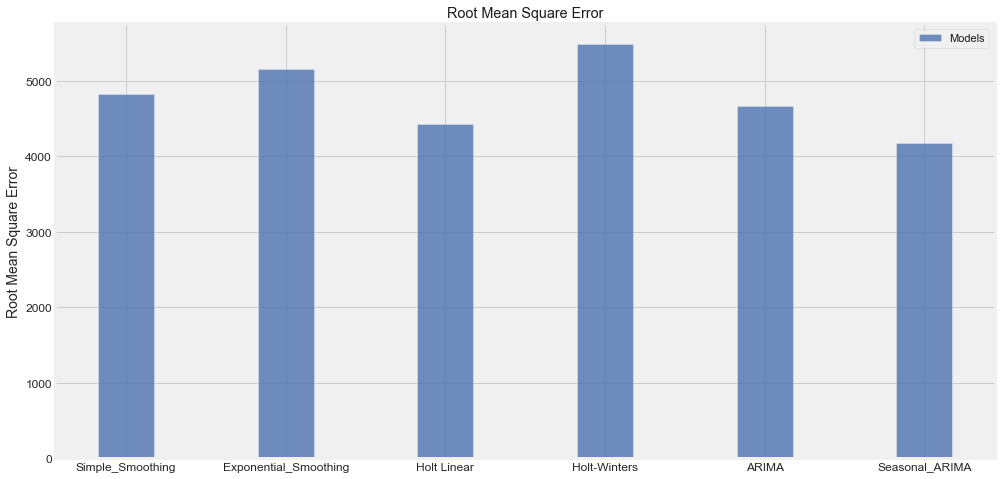

In [244]:
# create groups for
n_groups = 6
MSE = (SS_RMSE, ES_RMSE, HL_RMSE, HW_RMSE, A_RMSE, SA_RMSE)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
 
rects2 = plt.bar(index + bar_width, MSE, bar_width, alpha=opacity, color='b', label='Models')
 
plt.ylabel('Root Mean Square Error')
plt.title('Root Mean Square Error')
plt.xticks(index + bar_width, ('Simple_Smoothing', 'Exponential_Smoothing', 'Holt Linear', 'Holt-Winters', 'ARIMA', 'Seasonal_ARIMA'))
plt.legend()